In [1]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [2]:
import sys
import os

basedrive = "drive/My Drive/upper limb use assessment"
os.chdir(basedrive)
sys.path.append("scripts")

In [3]:
!pip install ahrs

In [4]:
!pip install scikit-learn==0.23

In [5]:
!pip install scikit-posthocs

In [6]:
import pandas as pd
from scipy import stats
from scikit_posthocs import posthoc_ttest
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import numpy as np

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
import classification_algorithms as ca
import reduced_models as rm
import task_analysis as ta

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Which is the best measure for assessing upper limb use?

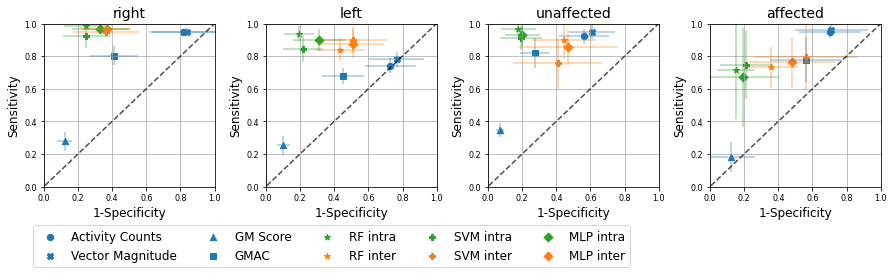

In [8]:
ca.plot_comparison_roc()
plt.savefig('results/comparison_roc.png', format='png', dpi=300, bbox_inches='tight')

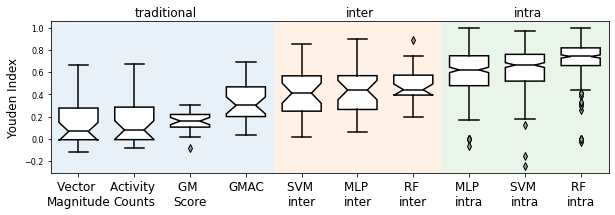

In [8]:
ca.plot_youden_boxplot()
plt.savefig('results/comparison_youden.png', format='png', dpi=300, bbox_inches='tight')

In [9]:
res = pd.read_csv('results/comparison.csv')
res['group'] = ['inter' if x.find('inter')!=-1 else 'intra' if x.find('intra')!=-1 else 'traditional' for x in res['method']]
res.groupby('method').median().sort_values('youden')[['sensitivity', 'specificity', 'youden']]

,sensitivity,specificity,youden
method,,,
Vector Magnitude,0.937817,0.177419,0.065757
Activity Counts,0.918649,0.226668,0.078758
GM Score,0.281176,0.896818,0.159520
GMAC,0.744972,0.555562,0.300606
SVM inter,0.931327,0.491964,0.410300
MLP inter,0.924156,0.516680,0.437774
RF inter,0.923001,0.566225,0.441216
MLP intra,0.937500,0.733333,0.619165
SVM intra,0.886364,0.786797,0.662393


In [10]:
stats.f_oneway(*[df['youden'].values for group, df in res.fillna(0).groupby('group')])

F_onewayResult(statistic=342.4640323008073, pvalue=1.6702133146009102e-116)

In [11]:
posthoc_ttest(res.fillna(0), 'youden', 'group', p_adjust='bonferroni')

,traditional,intra,inter
traditional,1.000000e+00,3.242476e-108,5.991283e-17
intra,3.242476e-108,1.000000e+00,1.337956e-22
inter,5.991283e-17,1.337956e-22,1.000000e+00


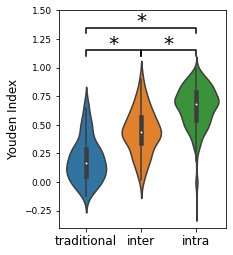

In [12]:
plt.figure(figsize=(3, 4))
order = ['traditional', 'inter', 'intra']
sns.violinplot(data=res, y='youden', x='group', order=order, )

x1, x2 = 0, 1
y, h, col = res['youden'].max()+0.1, 0.05, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+0.02, "*", fontsize=20, ha='center', va='bottom', color=col)

x1, x2 = 1, 2 
y, h, col = res['youden'].max()+0.1, 0.05, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+0.02, "*", fontsize=20, ha='center', va='bottom', color=col)

x1, x2 = 0, 2
y, h, col = res['youden'].max()+0.3, 0.05, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+0.02, "*", fontsize=20, ha='center', va='bottom', color=col)

plt.xticks(fontsize=12)
plt.yticks(fontsize=9)
plt.ylim(-0.4, 1.5)
plt.ylabel('Youden Index', fontsize=12)
plt.xlabel(None)
plt.savefig('results/comparison_significant.png', format="png", dpi=300, bbox_inches='tight')

# What does the random forest classifier do?

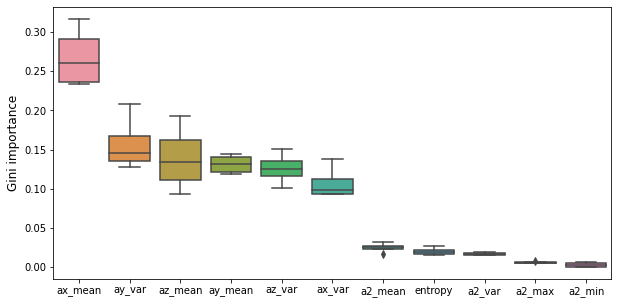

In [31]:
from sklearn.ensemble import RandomForestClassifier

l, r = ca.read_features('control')
a, u = ca.read_features('patient')

features = ['ax_mean', 'ax_var', 'ay_mean', 'ay_var', 'az_mean', 'az_var', 'a2_mean', 'a2_var', 'a2_min', 'a2_max', 'entropy']
target = ['t_mid']
clf = RandomForestClassifier(class_weight='balanced')

clf.fit(l[features].values, l[target].values.reshape(-1))
limp = clf.feature_importances_

clf.fit(r[features].values, r[target].values.reshape(-1))
rimp = clf.feature_importances_

clf.fit(a[features].values, a[target].values.reshape(-1))
aimp = clf.feature_importances_

clf.fit(u[features].values, u[target].values.reshape(-1))
uimp = clf.feature_importances_

imp = pd.DataFrame(np.vstack((limp, rimp, aimp, uimp)), columns=features)

plt.figure(figsize=(10,5))
sns.boxplot(data=imp, order=list(imp.median().sort_values(ascending=False).index))
plt.ylabel('Gini importance', fontsize=12)
plt.savefig('results/gini.png', format='png', dpi=300, bbox_inches='tight')

In [8]:
res = pd.read_csv('results/reduced_models.csv')

for typ, typdf in res.groupby('type'):
  print(typ, stats.f_oneway(*[df['youden'].values for group, df in typdf.fillna(0).groupby('method')]))

control inter F_onewayResult(statistic=6.678059597996654, pvalue=0.00046214800844998725)
control intra F_onewayResult(statistic=197.58155659924367, pvalue=9.29695724341718e-96)
patient inter F_onewayResult(statistic=6.396857065393869, pvalue=0.0013789181966366657)
patient intra F_onewayResult(statistic=27.682826835955346, pvalue=2.84911672000923e-16)


In [9]:
for typ, typdf in res.groupby('type'):
  print(typ)
  print((posthoc_ttest(typdf.fillna(0), 'youden', 'method', p_adjust='bonferroni')).to_markdown())
  print('\n')

control inter
|                       |       full |   mean of ax |   all mean |   all mean and variance |
|:----------------------|-----------:|-------------:|-----------:|------------------------:|
| full                  | 1          |   0.00074172 |  1         |              1          |
| mean of ax            | 0.00074172 |   1          |  0.0101894 |              0.00102602 |
| all mean              | 1          |   0.0101894  |  1         |              1          |
| all mean and variance | 1          |   0.00102602 |  1         |              1          |


control intra
|                       |        full |   mean of ax |    all mean |   all mean and variance |
|:----------------------|------------:|-------------:|------------:|------------------------:|
| full                  | 1           |  1.71059e-53 | 0.0905028   |             1           |
| mean of ax            | 1.71059e-53 |  1           | 3.43382e-46 |             1.53074e-52 |
| all mean              | 0.0905

In [8]:
def draw_significant_bars(x1, x2, ymax, level=None):
  if level>-1:
    diff = [-0.3, -0.1, 0.1, 0.3]
    x1 = level + diff[x1]
    x2 = level + diff[x2]
  y, h, col = ymax+0.05, 0.05, 'k'
  plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
  plt.text((x1+x2)*.5, y+0.02, "*", fontsize=15, ha='center', va='bottom', color=col)

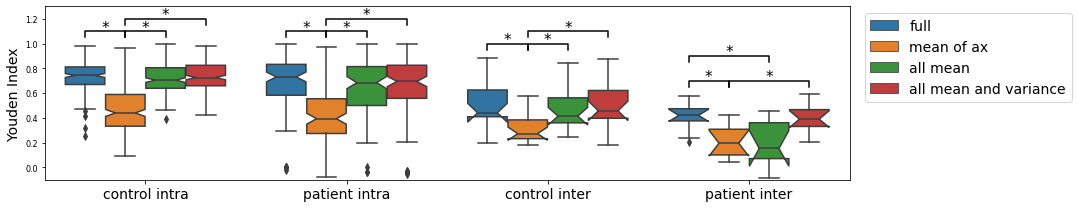

In [9]:
rm.plot_reduced_model_results()

draw_significant_bars(0, 1, 1, level=0)
draw_significant_bars(1, 2, 1, level=0)
draw_significant_bars(1, 3, 1.1, level=0)

draw_significant_bars(0, 1, 1, level=1)
draw_significant_bars(1, 2, 1, level=1)
draw_significant_bars(1, 3, 1.1, level=1)

draw_significant_bars(0, 1, 0.9, level=2)
draw_significant_bars(1, 2, 0.9, level=2)
draw_significant_bars(1, 3, 1, level=2)

draw_significant_bars(0, 1, 0.6, level=3)
draw_significant_bars(1, 3, 0.6, level=3)
draw_significant_bars(0, 2, 0.8, level=3)

plt.ylim(-0.1, 1.3)
plt.savefig('results/reduced_models.png', format='png', dpi=300, bbox_inches='tight')

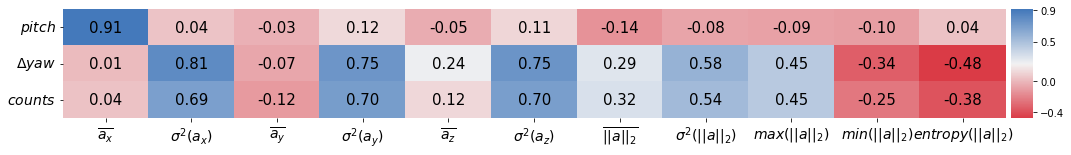

In [8]:
corr = rm.compute_corr_matrix()
plt.savefig('results/corr_matrix.png', format='png', dpi=300, bbox_inches='tight')

# Does adding a gyroscope improve classifier performance?

In [8]:
res = pd.read_csv('results/with_gyro.csv')
res['group'] = 'inter without gyro'
res.loc[res['method'].str.contains('ginter'), 'group'] = 'inter with gyro'
res.loc[res['method'].str.contains('intra'), 'group'] = 'intra without gyro'
res.loc[res['method'].str.contains('gintra'), 'group'] = 'intra with gyro'

pd.DataFrame([[group, df['sensitivity'].mean(), df['sensitivity'].std(), df['specificity'].mean(), df['specificity'].std()] 
              for group, df in res.groupby('group')], columns=['group', 'sens_mean', 'sens_std', 'spec_mean', 'spec_std'])

,group,sens_mean,sens_std,spec_mean,spec_std
0,inter with gyro,0.887711,0.138767,0.640720,0.152215
1,inter without gyro,0.867877,0.109382,0.595508,0.162197
2,intra with gyro,0.963484,0.025751,0.774957,0.084291
3,intra without gyro,0.924719,0.121733,0.791148,0.080642


In [9]:
print('sensitivity', 'inter', stats.f_oneway(*[df['sensitivity'].values for group, df in res.fillna(0).groupby('group') if group.find('inter')!=-1]))
print('specificity', 'inter', stats.f_oneway(*[df['specificity'].values for group, df in res.fillna(0).groupby('group') if group.find('inter')!=-1]))
print('sensitivity', 'intra', stats.f_oneway(*[df['sensitivity'].values for group, df in res.fillna(0).groupby('group') if group.find('intra')!=-1]))
print('specificity', 'intra', stats.f_oneway(*[df['specificity'].values for group, df in res.fillna(0).groupby('group') if group.find('intra')!=-1]))

sensitivity inter F_onewayResult(statistic=0.3780183227582984, pvalue=0.5410704298922642)
specificity inter F_onewayResult(statistic=1.2394016938352204, pvalue=0.27017906818952897)
sensitivity intra F_onewayResult(statistic=2.4370396104150367, pvalue=0.12445159891376731)
specificity intra F_onewayResult(statistic=0.5275810076724549, pvalue=0.4708214055487001)


# How does the nature of the dataset affect a machine learning method's performance?

## Proportion of functional and non-functional data

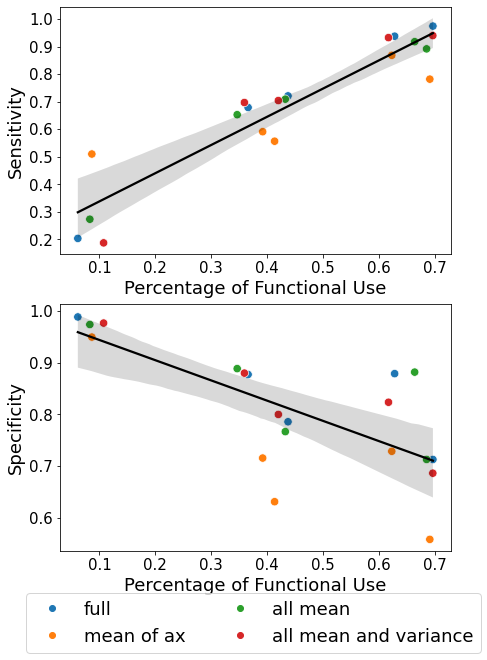

In [8]:
ta.plot_proportion_vs_performance()
plt.savefig('results/proportion.png', format="png", dpi=300, bbox_inches='tight')

## Presence/absence of tasks in testing/training datasets

walk
left sensitivity F_onewayResult(statistic=0.05865408906286863, pvalue=0.9810689959873979)
left specificity F_onewayResult(statistic=10.386119790295341, pvalue=4.576364535181407e-05)
right sensitivity F_onewayResult(statistic=1.2274882823282343, pvalue=0.3138510600494042)
right specificity F_onewayResult(statistic=189.92860919604146, pvalue=4.055950714698987e-22)


drinkcup
left sensitivity F_onewayResult(statistic=0.9503767708998704, pvalue=0.4265894260793146)
left specificity F_onewayResult(statistic=0.7272462377565421, pvalue=0.5424385808848747)
right sensitivity F_onewayResult(statistic=0.3182185365690243, pvalue=0.8121083862855546)
right specificity F_onewayResult(statistic=0.014580955556621691, pvalue=0.9975514991516028)


openbottle
left sensitivity F_onewayResult(statistic=0.23050959369668153, pvalue=0.8745295827205932)
left specificity F_onewayResult(statistic=0.028051925982381112, pvalue=0.9935510208597886)
right sensitivity F_onewayResult(statistic=0.06297096745094294, p

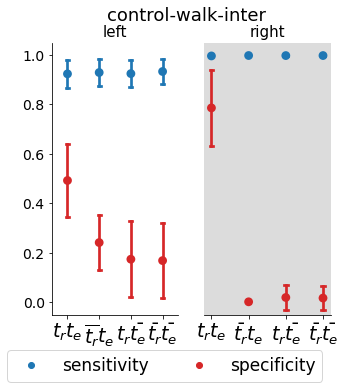

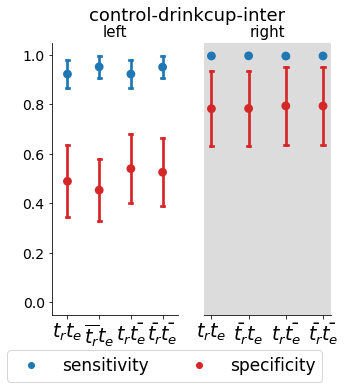

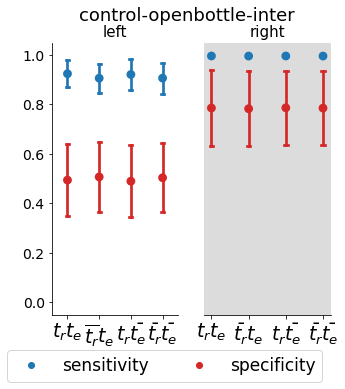

In [9]:
for task in ['walk', 'drinkcup', 'openbottle']:
  l, r = ta.plot_results_for_task(task, 'control', inter=True)
  print(task)
  print('left', 'sensitivity', stats.f_oneway(*[df['sensitivity'] for grp, df in l.fillna(0).groupby('method')]))
  print('left', 'specificity', stats.f_oneway(*[df['specificity'] for grp, df in l.fillna(0).groupby('method')]))
  print('right', 'sensitivity', stats.f_oneway(*[df['sensitivity'] for grp, df in r.fillna(0).groupby('method')]))
  print('right', 'specificity', stats.f_oneway(*[df['specificity'] for grp, df in r.fillna(0).groupby('method')]))
  print('\n')
  plt.savefig(f'results/control-{task}-inter.png', format="png", dpi=300, bbox_inches='tight')

walk
left sensitivity F_onewayResult(statistic=0.6241218608057192, pvalue=0.5997558814763688)
left specificity F_onewayResult(statistic=206.83144847568627, pvalue=1.07642382009529e-80)
right sensitivity F_onewayResult(statistic=1.0191813297588839, pvalue=0.38898230318169746)
right specificity F_onewayResult(statistic=91.37057940368905, pvalue=3.855268480591535e-25)


drinkcup
left sensitivity F_onewayResult(statistic=1.8937822307839427, pvalue=0.1300449922190091)
left specificity F_onewayResult(statistic=19.09436540433628, pvalue=1.3876343078338888e-11)
right sensitivity F_onewayResult(statistic=0.04309649717470033, pvalue=0.9880854535726955)
right specificity F_onewayResult(statistic=0.8347036984531812, pvalue=0.4754042696432834)


openbottle
left sensitivity F_onewayResult(statistic=6.04652456798861, pvalue=0.0004932428133936079)
left specificity F_onewayResult(statistic=0.25626565798846257, pvalue=0.8568617109882021)
right sensitivity F_onewayResult(statistic=0.2281754257610704, pva

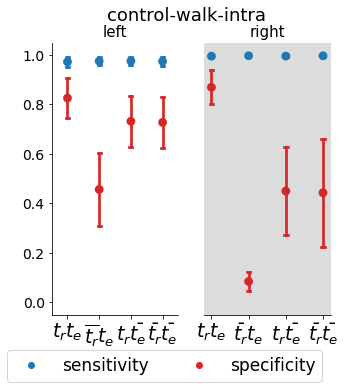

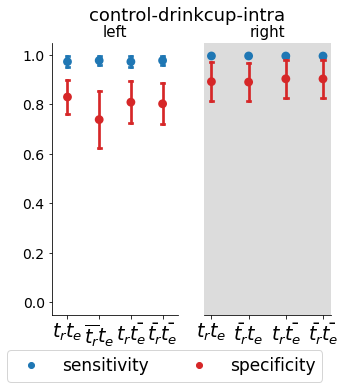

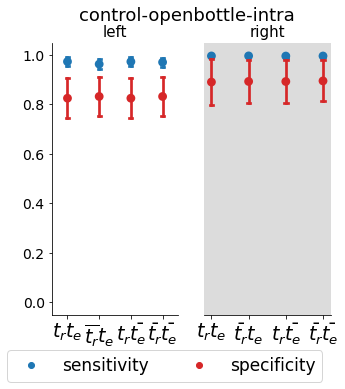

In [10]:
for task in ['walk', 'drinkcup', 'openbottle']:
  l, r = ta.plot_results_for_task(task, 'control', inter=False)
  print(task)
  print('left', 'sensitivity', stats.f_oneway(*[df['sensitivity'] for grp, df in l.fillna(0).groupby('method')]))
  print('left', 'specificity', stats.f_oneway(*[df['specificity'] for grp, df in l.fillna(0).groupby('method')]))
  print('right', 'sensitivity', stats.f_oneway(*[df['sensitivity'] for grp, df in r.fillna(0).groupby('method')]))
  print('right', 'specificity', stats.f_oneway(*[df['specificity'] for grp, df in r.fillna(0).groupby('method')]))
  print('\n')
  plt.savefig(f'results/control-{task}-intra.png', format="png", dpi=300, bbox_inches='tight')